#### PGDMLAI - IIIT Bangalore (Upgrad) ####
#### Gesture Recognition Case Study ####
Team Members:
1. Abhishek Rajan
2. Aiswarya Ramachandran
3. Anugraha Sinha
4. Vikash Sinha

# Gesture Recognition (Using Conv2D + SimpleRNN technique)
In this case, we will be using a CNN2D + SimpleRNN Network for evaluating geatures in videos. 
The data provided as following features
1. 30 Video frames in each video
2. Each frame - 3 Channel (RGB)
3. 5 kinds of gestures (Up, Down, Right, Left, Stop)

The objective is to be fullfilled for a hypothetical Smart TV company which is trying to incorporate geature recognition in its product where in the gestures mean following things

Gesture   |       Left       |    Right    |    Stop      |    Down     |     Up
----------| -----------------|-------------|--------------|-------------|-----------
Objectives| Previous Channel | Next Channel| Stop Playing | Volume Down | Volume Up
Y Value (Integer) | 0 | 1 | 2 | 3 | 4 

##### Library imports #####

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

##### We set the random seed so that the results don't vary drastically.#####

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


##### We set the train_doc and val_doc location #####
*Note : Please set this location as per your environment.*

In [3]:
train_doc = np.random.permutation(open('../../../Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../../../Project_data/val.csv').readlines())

#### Image Processor ####
The objective of this function is:
Resize the images as per *transform_size* given by user, or take it as (120,120)

**Reason**

In the training data we have 2 types of video, where video frame sizes are as *(360,360)* and *(160,120)* Therefore to keep things consistent, we build a image processor which perform cropping of the image.

**Note**

Cropping is done as a centered image, i.e., we take the center as the reference and crop the images from both sides. For (360,360) we can use skimage.transform.resize function. However, for *(160,120)* we will have to some manual processing to crop images by the center.

In [4]:
from skimage.transform import resize
def image_processor(orig_image,transform_size=(120,120)):
    # If we have an image of (360,360,3) then we use resize function.
    # If we have an image of 
    new_image = orig_image
    if orig_image.shape == (360,360,3):
        new_image = resize(orig_image,transform_size)
    else:
        start_row = (orig_image.shape[0] - transform_size[0])//2
        end_row = start_row + transform_size[0]
        
        start_col = (orig_image.shape[1] - transform_size[1])//2
        end_col = start_col + transform_size[1]
        new_image = orig_image[start_row:end_row,start_col:end_col,:]
    #new_image = resize(orig_image,transform_size)
    return(new_image)

#### Sequence Generator ####
This function provides a list of frame sequences we would like to use training

Arguments

a) choiceoflist


choicelist | 0 | 1 | 2
-----------|---|---|---
Return list type | range(0,30,1) | range(0,30,2) | [0,1,2,3,4,5,6,9,12,15,18,21,24,25,26,27,28,29]

In [5]:
def getframeselectionlist(choiceoflist=0):
    if choiceoflist==0:
        return [frame for frame in range(0,30,1)] # Returns 100% of frames, number of frames=30
    elif choiceoflist==1:
        return [frame for frame in range(0,30,2)] # returns 50% of frames, number of frames=15
    elif choiceoflist==2:
        
        # For this we are taking first 5 frame+skip frame sequence+last 5 frame of the sequence
        
        frame_sequence=[]
        
        startframesequence=[0,1,2,3,4,5]
        endframesequence=[25,26,27,28,29]
        skip_sequence=3  #
        middleframesequnce=[k for k in range(6,25,skip_sequence)]
        
        frame_sequence.extend(startframesequence)
        frame_sequence.extend(middleframesequnce)
        frame_sequence.extend(endframesequence)
        
        return frame_sequence

### Generator ###
This is heart of complete training process. It pumps batched data to network during learning and prediction both. The function description is given below

**Arguments**

1. Source Path - Directory path to be considered for reading video/images frames
2. folder_list - Lines from the train_doc we read above.
3. batch_size - The batch_size we want to select.
4. transform_size - The image transformation size we  (Default - (120,120)
5. frame_selection_list - frame_list obtained from frame_generator (Default - range(30))
6. process_input_func - To be provided in case CNN2D+RNN type modelling being done
7. base_model - To be provided in case CNN2D+RNN type modelling being done.

**Working**
* Case when CNN3D modelling being done

In this case, for each batch (according to batch size), we build 

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. We normalize each channel (RGB) by dividing the pixel value with 255.


* Case when CNN2D+RNN modelling being done (RNN can be any of SimpleRNN/LSTM/GRU)

In this case, for each batch (according to batch size), we build

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. reshape batch data as **batch_data.reshape(batch_size * number_of_frames , image_size_x , image_size_y , n_channels)**.
3. Above reshaped numpy array is sent to *process_input_func* of the pre-learned CNN2D function. This will produce modified image vector as per pre-learned CNN2D function (like VGG19/VGG16/etc.)
4. After *process_input_func* we reshape again to *(batch_size, number_of_frames, outputs from CNN2D vector)*


* Final Output

The final output of the function has a tuple which has the batch_data (processed) and one-hot-encoded Y variable.
One-hot-encoded numpy array will be of size (batch_size, 5) since we have 5 kind of gestures.


In [6]:
def generator(source_path,
              folder_list,
              batch_size,
              transform_size = (120,120),
              frame_selection_list = range(30),
              process_input_func=None,
              base_model = None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frame_selection_list
    channels = 3
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t) / batch_size) if len(t) % batch_size == 0 else (len(t) // batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(frame_selection_list),transform_size[0],transform_size[1],channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image_processor(image,transform_size)
                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                        
                    else:
                        # This is when we are building a Conv3D network
                        image = image/255

                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        # remaining data #
        if len(t) % batch_size != 0:                                      # Execute only if, we need to
            batch_data = np.zeros((len(t) % batch_size,len(frame_selection_list),transform_size[0],transform_size[1],channels))     # fix the last batch size
            batch_labels = np.zeros((len(t) % batch_size,5))              # Similarly, for labels
            for v_idx,folder in enumerate(t[(num_batches*batch_size):]):
                #print(folder.split(';')[0])
                imgs = os.listdir(source_path+"/"+folder.split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+folder.split(';')[0]+"/"+imgs[item]).astype(np.float32)
                    image = image_processor(image,transform_size)

                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                    else:
                        # This is when we are building a Conv3D network
                        image = image/255

                    batch_data[v_idx,idx,:,:,0] = image[:,:,0]
                    batch_data[v_idx,idx,:,:,1] = image[:,:,1]
                    batch_data[v_idx,idx,:,:,0] = image[:,:,2]
                batch_labels[v_idx,int(folder.split(";")[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
            yield batch_data,batch_labels

Recording *current_date-time* and fixing training data and validation data folder paths.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '../../../Project_data/train'
val_path = '../../../Project_data/val'

## Model
Setting up base information for model building process.

*IMPORTANT*
We are using VGG19 pre-trained model for CONV2D modelling.

If this code is CONV3D, then even though we are building the *base_model* and *preprocess_input_func* variables, but we will not use them further in the code.

If this code is CONV2D+RNN type modelling, then we will use *base_model* and *preprocess_input_func* variables further in the code.

In [8]:
train_data = train_doc
val_data = val_doc
transform_size = (120,120)
batch_size = 16
num_epochs = 40
frame_selection_list = getframeselectionlist(choiceoflist=0)
num_train_sequences = len(train_data)
num_val_sequences = len(val_data)
model_name = "model_init_conv2d_rnn"

from keras.applications.vgg19 import VGG19 as base_conv2d_model
from keras.applications.vgg19 import preprocess_input

base_model = base_conv2d_model(weights="imagenet",include_top=False)
preprocess_input_func = preprocess_input

os.environ.putenv("HDF5_USE_FILE_LOCKING","FALSE")

#### Building Neural Network Model Architecture ####

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Bidirectional, SimpleRNN, LSTM, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list,
                              process_input_func=preprocess_input_func,
                              base_model=base_model))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(SimpleRNN(64,
                    return_sequences = True,
                    input_shape=(input_sample[0].shape[1],input_sample[0].shape[2])))
model.add(SimpleRNN(64))

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  ../../../Project_data/train ; batch size = 16


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Input Sample shape : (16, 30, 4608)


#### Setting up Neural Network configurations ####

Optimizers
loss function and metrics to be monitored.

Watch out for model summary for verifications.

In [10]:
optimizer = optimizers.SGD(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30, 64)            299072    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 307,653
Trainable params: 307,653
Non-trainable params: 0
_________________________________________________________________
None


#### Building up generator objects ####

train_generator for training data

val_generator for validation data

In [11]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list,
                            process_input_func=preprocess_input_func,
                            base_model=base_model)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list,
                          process_input_func=preprocess_input_func,
                          base_model=base_model)

#### Setting up extra parameter for Neural Network ####

* ModelCheckPoint

We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.
* ReduceLROnPlateau

If the **val_loss** value stops improving after **patience** number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.

In [11]:
model_name = model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)

callbacks_list = [checkpoint, LR]
#callbacks_list = [checkpoint]
#callbacks_list = []
print("Model to be saved in directory : %s" %(model_name))

model_init_conv2d_rnn_2018-12-2808_32_25.080593/


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
conv2d_simple_rnn_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
Source path =  ../Project_data/train ; batch size = 16
Source path =  ../Project_data/val ; batch size = 16


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 7/42 [====>.........................] - ETA: 2:43 - loss: 1.7441 - categorical_accuracy: 0.2411

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


42/42 [==============================] - 181s 4s/step - loss: 1.4857 - categorical_accuracy: 0.3763 - val_loss: 1.2259 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_conv2d_rnn_2018-12-2808_32_25.080593/model-00001-1.48753-0.37557-1.22586-0.55000.h5
Epoch 2/40
42/42 [==============================] - 179s 4s/step - loss: 1.1106 - categorical_accuracy: 0.5735 - val_loss: 1.1062 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_conv2d_rnn_2018-12-2808_32_25.080593/model-00002-1.11144-0.57164-1.10618-0.58000.h5
Epoch 3/40
42/42 [==============================] - 179s 4s/step - loss: 0.9225 - categorical_accuracy: 0.6572 - val_loss: 1.0001 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_conv2d_rnn_2018-12-2808_32_25.080593/model-00003-0.91227-0.66214-1.00005-0.60000.h5
Epoch 4/40
42/42 [==============================] - 177s 4s/step - loss: 0.7938 - categorical_accuracy: 0.7023 - val_loss: 1.0499 - val_categ

#### Building graphs #####

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


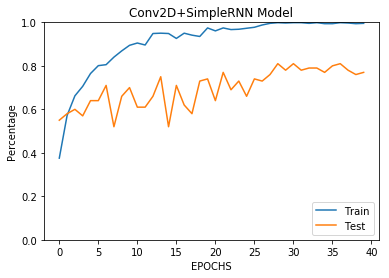

In [14]:
import matplotlib.pyplot as plt
plt.plot(conv2d_simple_rnn_model.history["categorical_accuracy"])
plt.plot(conv2d_simple_rnn_model.history["val_categorical_accuracy"])
plt.xlabel("EPOCHS")
plt.ylabel("Percentage")
plt.ylim(0.0,1.0)
plt.title("Conv2D+SimpleRNN Model")
plt.legend(["Train","Test"],loc="lower right")
plt.show()

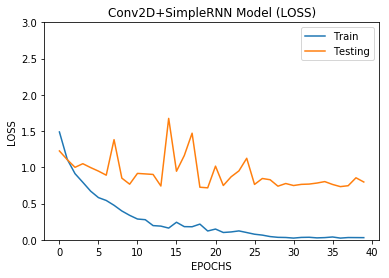

In [15]:
plt.plot(conv2d_simple_rnn_model.history["loss"])
plt.plot(conv2d_simple_rnn_model.history["val_loss"])
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0.0,3.0)
plt.title("Conv2D+SimpleRNN Model (LOSS)")
plt.legend(["Train","Testing"],loc="upper right")
plt.show()

#### Checking the EPOCH index where maximum validation accuracy was achieved ####

In [16]:
print("Maximum Validation Accuracy = %f achieved at epoch iteration = %d" %(np.array(conv2d_simple_rnn_model.history["val_categorical_accuracy"]).max(),np.array(conv2d_simple_rnn_model.history["val_categorical_accuracy"]).argmax() + 1))
sel_model_idx = np.array(conv2d_simple_rnn_model.history["val_categorical_accuracy"]).argmax() + 1

Maximum Validation Accuracy = 0.810000 achieved at epoch idx = 28


#### Selecting h5 file for loading model ####

In [17]:
import os
import re
search_string = "model-0*" + str(sel_model_idx) + "-[a-z0-9\-\.]*"
selected_model_name = model_name + list(filter(lambda x: re.search(search_string,x),os.listdir(model_name)))[0]
print("Selected model name : %s" %(selected_model_name))

Selected model name : model_init_conv2d_rnn_2018-12-2808_32_25.080593/model-00028-0.04460-0.99548-0.82870-0.76000.h5


#### Loading model weights from h5 file ####

In [13]:
from keras.models import clone_model
selected_model = clone_model(model)
selected_model.load_weights(selected_model_name)

#### Performing prediction on validation data ####

In [14]:
testing_val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list,
                          process_input_func=preprocess_input_func,
                          base_model=base_model)
result = None
for x in range(validation_steps):
    x_val,y_val = next(testing_val_generator)
    p_val = selected_model.predict(x_val,batch_size=batch_size,verbose=1)
    if x == 0:
        result = np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))
    else:
        result = np.hstack((result,np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))))

Source path =  ../../../Project_data/val ; batch size = 16


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


16/16 [==============================] - 0s 2ms/step


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


4/4 [==============================] - 0s 5ms/step


#### Consolidating Results ####

In [15]:
result = pd.DataFrame(np.transpose(result),columns=["Actual","Predicted"])

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [17]:
cf_np = confusion_matrix(result.Actual,result.Predicted,labels=range(0,5))
cf_df = pd.DataFrame(cf_np,columns=["Predicted_" + str(x) for x in ["Left","Right","Stop","Down","Up"]],index=["Actual_" + str(x) for x in ["Left","Right","Stop","Down","Up"]])
cf_df

,Predicted_Left,Predicted_Right,Predicted_Stop,Predicted_Down,Predicted_Up
Actual_Left,10,6,2,0,0
Actual_Right,5,17,0,1,0
Actual_Stop,1,0,20,0,1
Actual_Down,0,0,0,21,0
Actual_Up,0,0,5,0,11


In [20]:
print("Cummalative General Accuracy Score : %f" %(accuracy_score(result.Actual,result.Predicted)))
print("Cummalative Categorical Accuracy : %f" %(0.8100))

Cummalative General Accuracy Score : 0.790000
Cummalative Categorical Accuracy : 0.810000
